<font size="5" color='red'> <b>In this code the failure envelope is obtained with the UCS sample PB18 and the failure of PB20 in the last cycle.
<br>
The rest of the cycles from 1 to 4 of the PB20 sample, are representing the yield strength of the sample <b> </font>

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import linregress
from scipy.signal import butter,filtfilt, find_peaks

In [2]:
def Generate_Mohr_circle(Stress_yield, Stress_radial):
    ra = (Stress_yield-Stress_radial)/2
    ca = (Stress_yield+Stress_radial)/2
    theta = np.linspace(0,180,1000) * np.pi/180


    mohr_x = ra * np.cos(theta) + ca
    mohr_y = ra * np.sin(theta)

    return mohr_x, mohr_y

In [3]:
def mohr_coulomb(s1a, s3a, s1b, s3b):
#  Find the parameters necessary to draw the Mohr-Coulomb failure envelope
#  Idea behind function:
#        With the function we try to find the Tangent points on outside
#        of the circles. We then connect a line between the two tangent
#        points.
#        To make sure my script works, I need my "first" circle to be located
#        to the left, and the "second" circle to be located to the right.
#        This requirement is the first step in the script below. To do this,
#        we create a temporary matrix M

    M = ([(s1a-s3a)/2,(s1a+s3a)/2],
         [(s1b-s3b)/2,(s1b+s3b)/2])
    # Min_point = np.minimum(M[:1])
    Min_point = M[0]
    ca = ([Min_point[1], 0])
    ra = Min_point[0]
    # print(ca, ra)
    Max_point = M[1]
    cb = ([Max_point[1], 0])
    rb = Max_point[0]
#     print(cb, rb)

    a21 = cb[0]-ca[0]
    b21 = cb[1]-ca[1]
    d2 = a21**2 + b21**2
    r21 = (rb-ra)/d2
    # print(a21)


    s21 = np.sqrt(d2-(rb-ra)**2)/d2

    u1 = ([-a21*r21-b21*s21,-b21*r21+a21*s21]) # Left unit vector
    u2 = ([-a21*r21+b21*s21,-b21*r21-a21*s21])# Right unit vector
    # print(u1,u2)


    L1 = np.add([ca[0],ca[1]], np.multiply(ra,u1))
    L2 = np.add([cb[0],cb[1]], np.multiply(rb,u1)) # Left line tangency points
    R1 = np.add([ca[0],ca[1]], np.multiply(ra,u2))
    R2 = np.add([cb[0],cb[1]], np.multiply(rb,u2)) # Right line tangency points

    theta = np.linspace(0,180,1000)*(np.pi/180)                      # Potential range of Theta

    mohr_x1 = ra * np.cos(theta) + ca[0]
    mohr_y1 = ra * np.sin(theta) + ca[1]
   
    mohr_x2 = rb * np.cos(theta) + cb[0]
    mohr_y2 = rb * np.sin(theta) + cb[1]

    ##Now we wish to export the tangent line as Y = aX + b:
    x = [L1[0], L2[0]]
    y = [L1[1], L2[1]]
    c = np.linalg.solve(([1, x[0]],[1, x[1]]), np.transpose(y))                        # Calculate Parameter Vector
    a = c[1]
    b = c[0]
    # print(a, b)

    theta = np.pi-(np.arctan(np.absolute(u1[1])/np.absolute(u1[0])))

    return theta, a, b


In [4]:
First_var = 75.29
Second_var = 98.94
Third_var = 124.55
Fourth_var = 145.16
Fifth_var = 245.1345          # Max stress of failure at the last cycle of PB5 with CP of 50
Sixth_var = 24.9827           # Max stress of failure with the PB18 ('analogue' sample to PB20)

theta05,a05,b05 = mohr_coulomb(Sixth_var, 0, Fifth_var, 50)
theta12,a12,b12 = mohr_coulomb(First_var, 10, Second_var, 20)
theta13,a13,b13 = mohr_coulomb(First_var, 10, Third_var, 30)
theta14,a14,b14 = mohr_coulomb(First_var, 10, Fourth_var, 40)
theta23,a23,b23 = mohr_coulomb(Second_var, 20, Third_var, 30)
theta24,a24,b24 = mohr_coulomb(Second_var, 20, Fourth_var, 40)
theta34,a34,b34 = mohr_coulomb(Third_var, 30, Fourth_var, 40)

xrange = np.linspace(0,150)
y_05 = a05*xrange+b05                               # Line with slope a05

mohr_x0,mohr_y0 = Generate_Mohr_circle(Sixth_var,0)
mohr_x1,mohr_y1 = Generate_Mohr_circle(First_var, 10)
mohr_x2,mohr_y2 = Generate_Mohr_circle(Second_var, 20)
mohr_x3,mohr_y3 = Generate_Mohr_circle(Third_var, 30)
mohr_x4,mohr_y4 = Generate_Mohr_circle(Fourth_var, 40)
mohr_x5,mohr_y5 = Generate_Mohr_circle(Fifth_var,50)

Text(0, 0.5, '$\\tau [MPa]$')

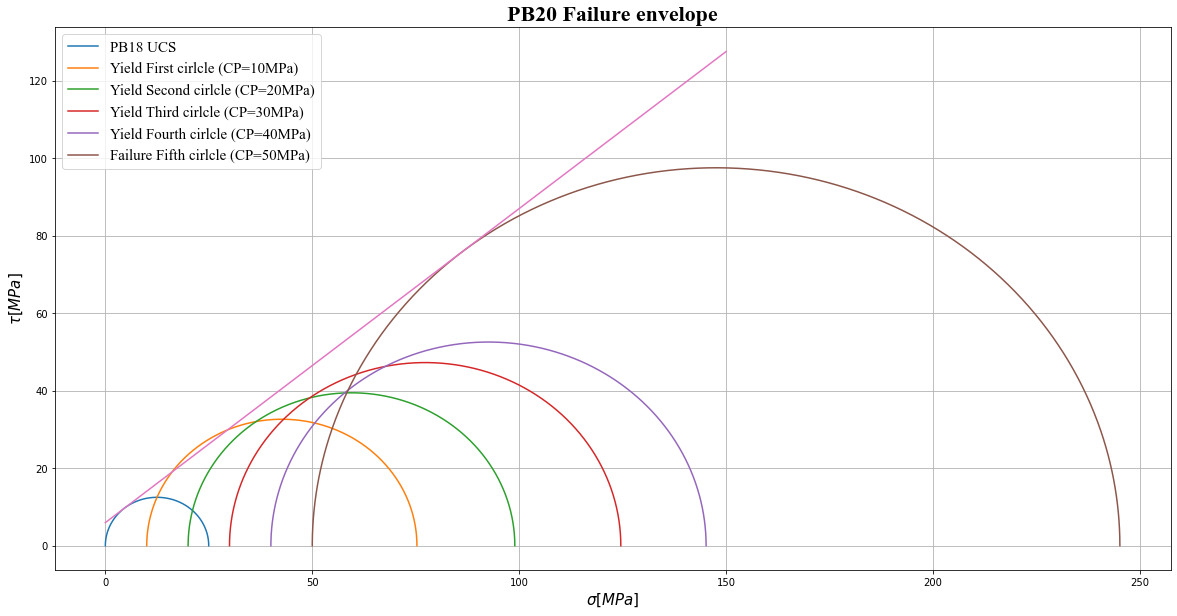

In [5]:
csfont = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15}

tfont = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}



# csfont = {'fontname':'Times New Roman'}

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(mohr_x0,mohr_y0, label='PB18 UCS')
ax.plot(mohr_x1,mohr_y1, label='Yield First cirlcle (CP=10MPa)')
ax.plot(mohr_x2,mohr_y2, label='Yield Second cirlcle (CP=20MPa)')
ax.plot(mohr_x3,mohr_y3, label='Yield Third cirlcle (CP=30MPa)')
ax.plot(mohr_x4,mohr_y4, label='Yield Fourth cirlcle (CP=40MPa)')
ax.plot(mohr_x5,mohr_y5, label='Failure Fifth cirlcle (CP=50MPa)')
ax.plot(xrange,y_05)
ax.grid()
# ax.set_xlim(0, 220)
# ax.set_ylim(0, 110)
plt.legend(loc='upper left', prop=csfont)
plt.title('PB20 Failure envelope',**tfont)
plt.xlabel(r'$\sigma [MPa]$', **csfont)
plt.ylabel(r'$\tau [MPa]$', **csfont)